In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

INF = 99.0
X, O, BLANK = 'X', 'O', ' '
N = 8
DOWN, UP = 1, -1

class State():
    
    def __init__(self, state=None, N=N):
        self.board = X*N + BLANK*(N-2)*N + O*N
        self.turn = X
        
        if state is not None:
            if type(state) is str:
                self.board = state
            else:
                self.board = state.board
                self.turn = state.turn 
            
    def move(self, move):
        ''' Moves players piece from Start to End index '''
        s, e = move
        player = self.board[s]
        # Remove piece
        self.board = self.board[:s] + BLANK + self.board[s+1:]
        # Place piece
        self.board = self.board[:e] + player + self.board[e+1:] 
        self.turn = X if self.turn == O else O
    
    def terminal_test(self):
        ''' Returns the victorious player if there is one '''
        # All pieces taken
        if X not in self.board:
            return -INF
        if O not in self.board:
            return INF
        
        # Check if either player has crossed board
        if X in self.board[N*(N-1):]:
            return INF
        if O in self.board[:N]:
            return -INF
        
        # Check if player cannot move, (return opponent as winner if so)
        if len(self.actions()) == 0:
            return INF if self.turn == O else -INF
        
        return None
            
    def __str__(self):        
        return (2*N+1)*'_' + ''.join(['\n|' + ''.join([e + '|' for e in self.board[i:i+N]]) + ' ' + \
                                     ''.join([str(j).rjust(3) for j in range(i, i+N)]) for i in range(0, N**2, N)])    
    
    def __repr__(self):
        return str(self)
    
    def actions(self):
        ''' Returns a list of possible actions for the player '''
        player   = X if self.turn == X else O
        opponent = O if self.turn == X else X
        direction = DOWN if player == X else UP
    
        # Find pieces
        lst = [i for i in range(N**2) if self.board[i] == player]

        actions = []
        for i in lst:
            # Check vertical is valid and free
            if (0 <= i+N*direction < N**2) and (self.board[i+N*direction] == BLANK):
                actions.append((i, i+N*direction))

            # Check diagonals are valid and taken by opposition
            # If not on left, check left
            new_i = i + N*direction - 1
            if (i%N != 0) and (0 <= new_i) and (self.board[new_i] == opponent):
                actions.append((i, new_i))

            # If not on right, check right
            new_i = i + N*direction + 1
            if ((i+1)%N != 0) and (new_i < N**2) and (self.board[new_i] == opponent):
                actions.append((i, new_i))

        return actions
    
    def flip(self):
        board = ''
        for space in self.board:
            if space == X:
                board += O
            elif space == O:
                board += X
            else:
                board += BLANK
        self.board = board[::-1]
        self.turn = X if self.turn == O else X

In [2]:
def Φ(state):
    b = state.board

    def f(state, pos, player):
        return state.board[pos] == player
    
    def pieces(state, player):
        return state.board.count(player)
    
    def row(state, r, player):
        add = 0
        if player == O:
            add = N
        return state.board[N*r+add:N*(r+1)+add].count(player)
    
    def n_actions(b, player):
        s = State(b)
        s.turn = player
        return len(s.actions())
    
    def end_in_sight(board, column, player):
        ''' Doesnt account for situation XOX '''
        direction = DOWN if player == X else UP
        opponent = O if player == X else X
        col = [board[i] for i in range(column, N**2, N)][::direction]
        if player in col:
            if opponent in col and col.index(player) < col.index(opponent):
                return 0
            return 1
        return -1

    def furthest_piece(board, column, player):
        direction = DOWN if player == X else UP
        col = [board[i] for i in range(column, N**2, N)][::-direction]
        if player in col:
            return N - col.index(player) - 1
        return -1

    def n_pieces_can_attack(state, player):
        ''' Number of players pieces that can attack opponent '''
        s = State(state)
        s.turn = player

        attacks = []
        for a in s.actions():
            # If not vertical
            if not(a[0] + N == a[1] or a[0] - N == a[1]):
                attacks.append(a[0])

        return len(set(attacks))/N   

    def n_opp_can_be_attacked(state, player):
        ''' Number of opponents pieces that can be attacked '''
        s = State(state)
        s.turn = player

        attacks = []
        for a in s.actions():
            # If not vertical
            if not(a[0] + N == a[1] or a[0] - N == a[1]):
                attacks.append(a[1])

        return len(set(attacks))/N
        
    return np.array([n_actions(b, player) for player in [X, O]] +
                    [pieces(state, player) for player in [X, O]] +
                    [row(state, r, player) for player in [X, O] for r in range(N-1)] +
                    [end_in_sight(b, c, player) for player in [X, O] for c in range(N)] +
                    [furthest_piece(b, c, player) for player in [X, O] for c in range(N)] +
                    [n_pieces_can_attack(state, player) for player in [X, O]] +
                    [n_opp_can_be_attacked(state, player) for player in [X, O]] +
                    [f(state, pos, player) for player in [X, O] for pos in range(N**2)])

def H(s, θ):
    h = np.dot(Φ(s), θ)
    if h < -INF:
        return -INF*0.99
    if h > +INF:
        return +INF*0.99
    return h

α = 0.1
MAX_CHANGE = 0.1
def tree_strap_train(θ, depth=2, printing=False):
    state = State()
    turn = 0
    random_turns = np.random.choice([0] + [2]*2 + [4]*4 + [8]*8 + 16*[16] + 32*[32])
    
    print(state) if printing else None
    
    while state.terminal_test() is None:
        if turn < random_turns:
            state.move(state.actions()[np.random.choice([i for i in range(len(state.actions()))])])
        else:
            searched_states = []
            V = minimax(state, depth, True, θ, searched_states)
            h = H(state, θ)

            Δθ = np.zeros(len(θ))       
            for s, vs, hs in searched_states:
                #𝛿 = V(s) - H(s, θ)
                𝛿 = vs - hs
                Δθ += α*𝛿*Φ(s)
                s.flip()
                𝛿 = -(vs - hs)
                Δθ += α*𝛿*Φ(s)
            for i in range(len(Δθ)):
                if Δθ[i] > MAX_CHANGE:
                    Δθ[i] = MAX_CHANGE
                elif Δθ[i] < -MAX_CHANGE:
                    Δθ[i] = -MAX_CHANGE
            θ += Δθ

            actions = []
            for action in state.actions():
                result = State(state)
                result.move(action)
                actions.append((minimax(result, depth-1, False, θ), action))
                
            state.move(max(actions)[1])
                
        print(state) if printing else None 
        turn += 1
        state.flip()
    return θ

def minimax(state, depth, isMax, θ, searched_states=None):
    if state.terminal_test() is not None:
        return state.terminal_test()
    if depth == 0:
        return H(state, θ)
    
    if isMax:
        maxEval = -INF
        for a in state.actions():
            result = State(state)
            result.move(a)
            maxEval = max(maxEval, minimax(result, depth-1, not isMax, θ, searched_states))
        
        if searched_states is not None:
            # Store the state, it's V(s) and H(s)
            searched_states.append((state, maxEval, H(state, θ)))
        return maxEval
    
    else:
        minEval = +INF
        for a in state.actions():
            result = State(state)
            result.move(a)
            minEval = min(minEval, minimax(result, depth-1, not isMax, θ, searched_states))
            
        if searched_states is not None:
            # Store the state, it's V(s) and H(s)
            searched_states.append((state, minEval, H(state, θ)))
        return minEval

In [3]:
θ = np.array([   95.29514162,  -95.32204212,  168.67958351, -168.61292501,
                -25.48930166,    5.10000556,   20.68049691,    5.58026881,
                 18.00523452,    2.04928015,   47.31152548,  -47.36179418,
                 -2.21625825,  -17.95667322,   -5.74766491,  -20.70083325,
                 -5.23364856,   25.51943716,   24.27672353,    5.52589099,
                  1.49242246,   16.42478397,    0.33267099,   16.46492512,
                -17.55253561,   31.4272057 ,  -31.40919578,   17.66687399,
                -16.47902116,   -0.32148591,  -16.38503051,   -1.34096831,
                 -5.48564007,  -24.30165758,  -55.0774485 ,  -59.99040206,
                -36.58383422,  -64.52811392,  -33.11038353,  -71.49500978,
                -34.57631192,  -68.87264589,   68.85771589,   34.61037952,
                 71.46271078,   33.00173633,   64.49099092,   36.50829402,
                 60.00881886,   55.104467  ,   -2.81727564,    2.84974854,
                  2.85171584,   -2.92417014] + 
                [np.random.uniform(-0.1, 0.1) for _ in range(128)])

#θ = np.array([np.random.uniform(-0.1, 0.1) for _ in range(54)]) 
θs = [np.copy(θ)]
len(θ), len(Φ(State()))

(182, 182)

In [11]:
i = 0
while True:
    if i%10 == 0:
        print(i, end=' ')
    θ = tree_strap_train(θ, depth=3)
    θs.append(np.copy(θ))
    i += 1

0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420 430 440 450 460 470 480 490 500 510 520 530 540 550 560 570 580 590 600 610 620 630 640 650 660 670 680 690 700 710 720 730 740 750 760 770 780 790 800 810 820 830 840 850 860 870 880 890 900 910 920 930 940 950 960 970 980 990 1000 1010 1020 1030 1040 1050 1060 1070 1080 1090 1100 1110 1120 1130 1140 1150 1160 1170 1180 1190 1200 1210 1220 1230 1240 1250 1260 1270 1280 1290 1300 1310 1320 1330 1340 1350 1360 1370 1380 1390 1400 1410 1420 1430 1440 1450 1460 1470 1480 1490 1500 1510 1520 1530 1540 1550 1560 1570 1580 1590 1600 1610 1620 1630 1640 1650 1660 1670 1680 1690 1700 1710 1720 1730 1740 1750 1760 1770 1780 1790 1800 1810 1820 1830 1840 1850 1860 1870 1880 1890 1900 1910 1920 1930 1940 1950 1960 1970 1980 1990 2000 2010 2020 2030 2040 2050 2060 2070 2080 2090 2100 2110 2120 2130 2140 2150 2160 2170 2180 2190 2200 2210 2

KeyboardInterrupt: 

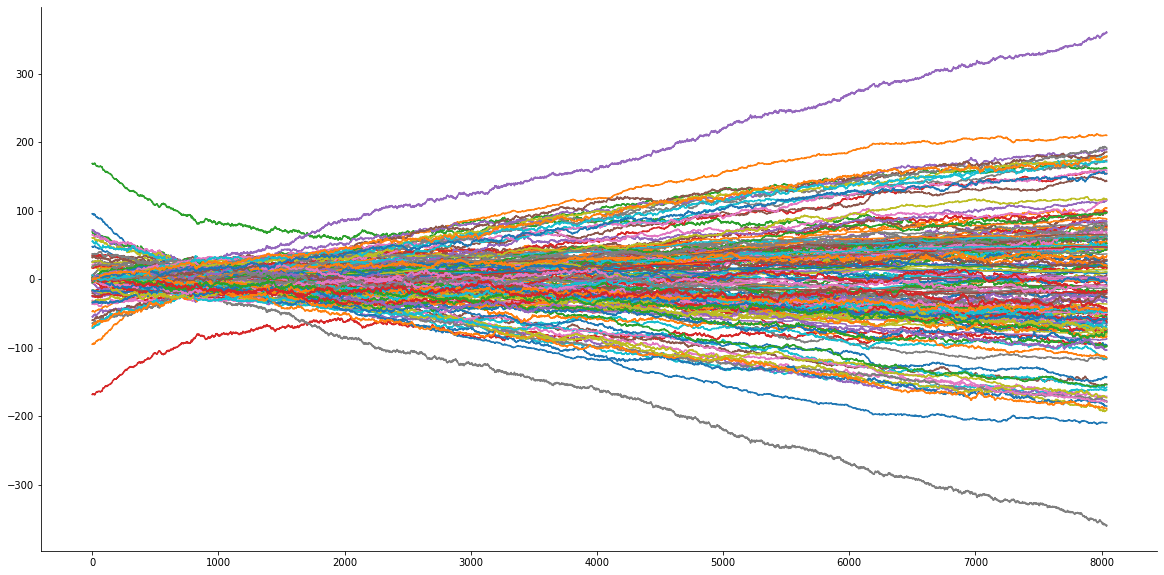

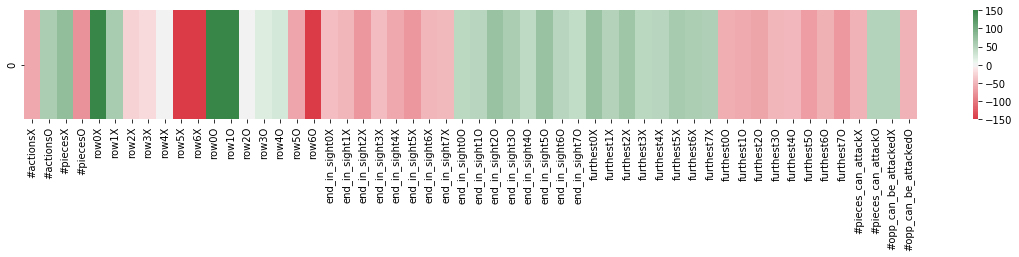

In [12]:
fig, ax = plt.subplots(figsize=(20, 10))
for i in range(len(θ)):
    x = [j for j in range(len(θs))]
    y = [θs[j][i] for j in range(len(θs))]
    ax.plot(x, y)
sns.despine()
plt.show()

FACTOR=150
cmap = sns.diverging_palette(10, 133, as_cmap=True)
lbls = ['#actionsX', '#actionsO', '#piecesX', '#piecesO'] + [f'row{r}{p}' for p in [X, O] for r in range(N-1)] + \
       [f'end_in_sight{c}{p}' for p in [X, O] for c in range(N)] + [f'furthest{c}{p}' for p in [X, O] for c in range(N)] + \
       ['#pieces_can_attackX', '#pieces_can_attackO', '#opp_can_be_attackedX', '#opp_can_be_attackedO']
fig, ax = plt.subplots(figsize=(20, 2))
sns.heatmap([θ[:len(θ)-128]], cmap=cmap, vmin=-FACTOR, vmax=FACTOR, ax=ax, xticklabels=lbls)
plt.show()

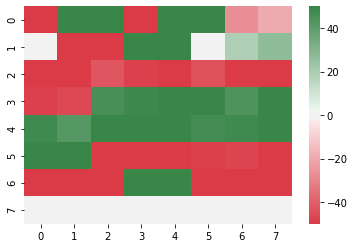

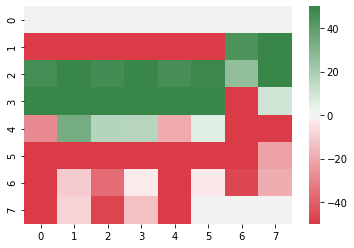

In [13]:
dataX = []
dataO = [np.array([0]*N)]
for i in range(0, N**2-N, N):
    dataX.append(θ[i:i+N])
dataX.append(np.array([0]*N))
    
for i in range(N**2-N, 2*(N**2-N), N):
    dataO.append(θ[i:i+N])
    
data = θ[2*(N**2-N):]
    
FACTOR = 50

cmap = sns.diverging_palette(10, 133, as_cmap=True)
sns.heatmap(dataX, cmap=cmap, vmin=-FACTOR, vmax=FACTOR)
plt.show()
sns.heatmap(dataO, cmap=cmap, vmin=-FACTOR, vmax=FACTOR)
plt.show()

In [27]:
TREESTRAP, RANDOM, HUMAN = 0, 1, 2

def ab_pruning(state, depth, α, β, θ, isMax):
    if state.terminal_test() is not None:
        return state.terminal_test()
    if depth == 0:
        return H(state, θ)
    
    if isMax:
        maxV = -INF
        for action in state.actions():
            result = State(state)
            result.move(action)
            value = ab_pruning(result, depth-1, α, β, θ, isMax=False)
            maxV = max(maxV, value)
            α = max(α, value)
            if β <= α:
                break
        return maxV
    else:
        minV = +INF
        for action in state.actions():
            result = State(state)
            result.move(action)
            value = ab_pruning(result, depth-1, α, β, θ, isMax=True)
            minV = min(minV, value)
            β = min(β, value)
            if β <= α:
                break
        return minV

def random_move(state, θ=None, depth=None):
    if depth is not None or θ is not None:
        raise ValueError 
    actions = state.actions()
    return actions[np.random.choice([i for i in range(len(actions))])]

def tree_strap_move(state, θ, depth=5):
    if depth is None:
        raise ValueError 
    
    actions = []
    for action in state.actions():
        result = State(state)
        result.move(action)
        # If terminal state, no need to search
        if result.terminal_test() is not None:
            rn = result.terminal_test()
            actions.append((rn, action))
        else:
            isMax = True if result.turn == X else False
            actions.append((ab_pruning(result, depth, -INF, INF, θ, isMax=isMax), action))
    
    if state.turn == X:
        #print(actions)
        return max(actions)[1]
    return min(actions)[1]

def play(playerX=TREESTRAP, playerO=HUMAN, θX=None, θO=None, depthX=None, depthO=None, printing=False):
    if playerX == HUMAN:
        raise ValueError('You Monster!')
        
    s = State()
    s.turn = np.random.choice([X, O])
    
    def play_human(ai):
        print(s)
        while s.terminal_test() is None:
            if s.turn == O:
                print('\n', list(enumerate(s.actions())), sep='')
                i = int(input())
                s.move(s.actions()[i])
            else:
                s.move(MOVE[playerX](s, θX, depthX))

            print(s)
        print('\nGame Over!')
    
    if playerO == HUMAN:
        play_human(ai=playerX)
    else:
        
        random_turns = np.random.choice([0] + [2]*2 + [4]*4 + [8]*8 + 16*[16] + 32*[32])
        print(s) if printing else None
        turn = 0
        while s.terminal_test() is None:
            if turn < random_turns:
                s.move(s.actions()[np.random.choice([i for i in range(len(s.actions()))])])
            else:
                if s.turn == X:
                    s.move(MOVE[playerX](s, θX, depthX))
                else:
                    s.move(MOVE[playerO](s, θO, depthO))
            print(s) if printing else None
            turn += 1
            
    θs.append(np.copy(θ))
    return int(s.terminal_test() > 0)

def validate(nGames=1, playerX=TREESTRAP, playerO=RANDOM, θX=θ, θO=None, depthX=2, depthO=None):
    wins = 0
    for _ in range(nGames):
        wins += play(playerX, playerO, θX, θO, depthX, depthO, printing=False)
    p = wins/nGames
    return p, (max(0, p - 1.96*np.sqrt(p*(1-p)/nGames)), min(1, p + 1.96*np.sqrt(p*(1-p)/nGames)))

MOVE = {TREESTRAP: tree_strap_move, RANDOM: random_move}

#validate(nGames=10)

In [28]:
wins = 0
total = 0
while True:
    total += 1
    wins += play(playerX=TREESTRAP, playerO=TREESTRAP, θX=θX, θO=θ, depthX=3, depthO=3, printing=False)
    p = wins/total
    print(p, (max(0, p - 1.96*np.sqrt(p*(1-p)/total)), min(1, p + 1.96*np.sqrt(p*(1-p)/total))))

0.0 (0, 0.0)
0.0 (0, 0.0)
0.0 (0, 0.0)
0.25 (0, 0.674352447854375)
0.4 (0, 0.8294144850840502)
0.5 (0.09991667534541426, 0.9000833246545857)
0.42857142857142855 (0.06196537297496135, 0.7951774841678958)
0.375 (0.03951993352808575, 0.7104800664719142)
0.4444444444444444 (0.11980050104447498, 0.7690883878444139)
0.5 (0.19009678930349883, 0.8099032106965012)
0.5454545454545454 (0.2511969573207727, 0.8397121335883182)
0.5833333333333334 (0.30438856248221097, 0.8622781041844558)
0.5384615384615384 (0.2674637865884742, 0.8094592903346027)
0.5 (0.2380839829258241, 0.7619160170741759)
0.5333333333333333 (0.28086134735527735, 0.7858053193113893)
0.5625 (0.31942159829594075, 0.8055784017040593)
0.5882352941176471 (0.3542806291426003, 0.8221899590926939)
0.6111111111111112 (0.38589851531349934, 0.836323706908723)
0.5789473684210527 (0.3569401957423196, 0.8009545410997857)
0.55 (0.3319637644793876, 0.7680362355206125)
0.5238095238095238 (0.3101985933082275, 0.7374204543108202)
0.5 (0.2910632979715

0.5167785234899329 (0.4365390113406238, 0.597018035639242)
0.52 (0.44004737402686517, 0.5999526259731349)
0.5231788079470199 (0.4435132789536316, 0.6028443369404082)
0.5263157894736842 (0.4469374643386749, 0.6056941146086935)
0.5294117647058824 (0.4503206524989842, 0.6085028769127805)
0.525974025974026 (0.44711000258678407, 0.604838049361268)
0.5225806451612903 (0.44394546368397964, 0.601215826638601)
0.5192307692307693 (0.44082602995662634, 0.5976355085049122)
0.5222929936305732 (0.44415825735629344, 0.600427729904853)
0.5253164556962026 (0.44745184459950615, 0.603181066792899)
0.5283018867924528 (0.4507074367093389, 0.6058963368755668)
0.53125 (0.45392566531566536, 0.6085743346843346)
0.5341614906832298 (0.4571071489570113, 0.6112158324094483)
0.5308641975308642 (0.4540149585218254, 0.6077134365399031)
0.5337423312883436 (0.45715779498090403, 0.6103268675957831)
0.5365853658536586 (0.4602653535867056, 0.6129053781206115)
0.5393939393939394 (0.46333820670550036, 0.6154496720823786)
0.

0.5435540069686411 (0.4859263220136449, 0.6011816919236374)
0.5416666666666666 (0.48412047279589576, 0.5992128605374375)
0.5432525951557093 (0.4858216320955195, 0.6006835582158991)
0.5448275862068965 (0.48751175650932493, 0.6021434159044681)
0.5463917525773195 (0.48919095088596676, 0.6035925542686723)
0.5445205479452054 (0.48739818335606927, 0.6016429125343417)
0.5426621160409556 (0.4856186899058422, 0.599705542176069)
0.54421768707483 (0.48728686352826517, 0.6011485106213947)
0.5457627118644067 (0.4889443923617121, 0.6025810313671014)
0.543918918918919 (0.4871777436472001, 0.6006600941906378)
0.5420875420875421 (0.485423990811979, 0.5987510933631052)
0.540268456375839 (0.48368299037070767, 0.5968539223809702)
0.5384615384615384 (0.48195460101894194, 0.5949684759041349)
0.54 (0.4836010212858425, 0.5963989787141576)
0.5382059800664452 (0.4818848661904038, 0.5945270939424865)
0.5364238410596026 (0.4801810088779541, 0.5926666732412511)
0.5379537953795379 (0.48181669859945486, 0.5940908921

0.5188679245283019 (0.4713088154304125, 0.5664270336261913)
0.52 (0.4725010623029005, 0.5674989376970996)
0.5211267605633803 (0.47368800983239934, 0.5685655112943612)
0.5199063231850117 (0.47251839991586186, 0.5672942464541616)
0.5186915887850467 (0.47135461228970016, 0.5660285652803934)
0.5174825174825175 (0.47019660293761467, 0.5647684320274203)
0.5186046511627908 (0.47137758227672505, 0.5658317200488565)
0.5174013921113689 (0.4702250498977138, 0.564577734325024)
0.5185185185185185 (0.471400596639354, 0.5656364403976829)
0.5196304849884527 (0.4725710018044417, 0.5666899681724636)
0.5207373271889401 (0.4737362984016978, 0.5677383559761824)
0.5195402298850574 (0.47258872156598436, 0.5664917382041306)
0.5206422018348624 (0.47374872768127324, 0.5675356759884516)
0.5217391304347826 (0.47490370360769896, 0.5685745572618662)
0.5228310502283106 (0.4760536813766519, 0.5696084190799692)
0.5216400911161732 (0.4749110704248707, 0.5683691118074756)
0.5227272727272727 (0.4760558949285098, 0.569398

0.5399644760213144 (0.49879454371354526, 0.5811344083290835)
0.5390070921985816 (0.49786741485983627, 0.5801467695373268)
0.5380530973451327 (0.49694376295341625, 0.5791624317368492)
0.5388692579505301 (0.4978014428609143, 0.5799370730401459)
0.5396825396825397 (0.4986562303777226, 0.5807088489873566)
0.5404929577464789 (0.4995081399042022, 0.5814777755887556)
0.5413005272407733 (0.5003571857474202, 0.5822438687341264)
0.5421052631578948 (0.5012033821218765, 0.583007144193913)
0.542907180385289 (0.5020467431502222, 0.5837676176203557)
0.5437062937062938 (0.5028872828639738, 0.5845253045486137)
0.5427574171029669 (0.501967297514949, 0.5835475366909848)
0.5435540069686411 (0.5028050801528813, 0.5843029337844009)
0.5443478260869565 (0.5036400742075878, 0.5850555779663252)
0.5434027777777778 (0.5027235791105878, 0.5840819764449677)
0.5441941074523396 (0.5035558525681918, 0.5848323623364875)
0.5449826989619377 (0.50438536961883, 0.5855800283050455)
0.5440414507772021 (0.5034723421052125, 0.

0.5449358059914408 (0.5080714995657257, 0.5818001124171558)
0.5441595441595442 (0.507316367051514, 0.5810027212675744)
0.5448079658605974 (0.5079952838008374, 0.5816206479203575)
0.5440340909090909 (0.507242464570233, 0.5808257172479488)
0.5446808510638298 (0.507919579573082, 0.5814421225545776)
0.5453257790368272 (0.5085948510467223, 0.5820567070269321)
0.5445544554455446 (0.5078443821801286, 0.5812645287109606)
0.5437853107344632 (0.5070961471809065, 0.58047447428802)
0.5430183356840621 (0.5063501359394686, 0.5796865354286556)
0.5422535211267606 (0.5056063384085127, 0.5789007038450086)
0.5414908579465542 (0.5048647446025267, 0.5781169712905816)
0.5407303370786517 (0.5041253445972992, 0.5773353295600042)
0.5399719495091164 (0.5033881285294339, 0.5765557704887989)
0.5406162464985994 (0.5040618744388564, 0.5771706185583424)
0.5398601398601398 (0.5033268645251497, 0.5763934151951299)
0.5391061452513967 (0.5025940159962559, 0.5756182745065375)
0.5383542538354253 (0.5018633191942219, 0.574

0.5423122765196663 (0.5086002825463175, 0.5760242704930151)
0.5428571428571428 (0.5091683712361215, 0.5765459144781642)
0.5422116527942925 (0.5085391913938857, 0.5758841141946993)
0.5415676959619953 (0.507911579038746, 0.5752238128852446)
0.5409252669039146 (0.5072855282389697, 0.5745650055688596)
0.5414691943127962 (0.5078524242222613, 0.575085964403331)
0.5420118343195266 (0.5084180268070194, 0.5756056418320338)
0.541371158392435 (0.5077935987962527, 0.5749487179886172)
0.5407319952774499 (0.5071707168683383, 0.5742932736865615)
0.5400943396226415 (0.5065493752091447, 0.5736393040361384)
0.5394581861012956 (0.5059295680342594, 0.5729868041683318)
0.5388235294117647 (0.505311289588793, 0.5723357692347364)
0.5393654524089306 (0.505875763948746, 0.5728551408691153)
0.539906103286385 (0.5064389611210076, 0.5733732454517624)
0.5392731535756154 (0.5058222606129693, 0.5727240465382616)
0.5398126463700235 (0.5063842145832587, 0.5732410781567883)
0.5403508771929825 (0.5069449013880319, 0.5737

0.5383828045035824 (0.5071223441877138, 0.569643264819451)
0.5388548057259713 (0.5076126230289213, 0.5700969884230214)
0.5393258426966292 (0.5081019341779769, 0.5705497512152815)
0.539795918367347 (0.5085902804675267, 0.5710015562671672)
0.5402650356778798 (0.5090776647193495, 0.5714524066364101)
0.5407331975560081 (0.5095640897444068, 0.5719023053676094)
0.5412004069175992 (0.5100495583428943, 0.572351255492304)
0.5416666666666666 (0.5105340733042911, 0.5727992600290421)
0.5421319796954315 (0.5110176374074099, 0.573246321983453)
0.5425963488843814 (0.5115002534204468, 0.5736924443483159)
0.5430597771023303 (0.5119819241010303, 0.5741376301036304)
0.5435222672064778 (0.5124626521962707, 0.5745818822166848)
0.5439838220424671 (0.512942440442809, 0.5750252036421252)
0.5444444444444444 (0.5134212915668653, 0.5754675973220235)
0.544904137235116 (0.5138992082842869, 0.5759090661859451)
0.5453629032258065 (0.5143761933005968, 0.5763496131510162)
0.5448136958710977 (0.5138394994147149, 0.5757

0.5461883408071749 (0.5169651472209623, 0.5754115343933875)
0.546594982078853 (0.5173871074776771, 0.575802856680029)
0.5461056401074306 (0.5169081709157565, 0.5753031092991047)
0.5465116279069767 (0.5173294331984332, 0.5756938226155203)
0.5460232350312779 (0.5168514232481309, 0.5751950468144249)
0.5464285714285714 (0.5172719898388171, 0.5755851530183257)
0.5459411239964318 (0.516794902922127, 0.5750873450707366)
0.5463458110516934 (0.5172147760918138, 0.5754768460115731)
0.5458593054318789 (0.5167386086513734, 0.5749800022123843)
0.5462633451957295 (0.5171577906600658, 0.5753688997313932)
0.5466666666666666 (0.5175762505451421, 0.5757570827881912)
0.5461811722912966 (0.5171010322557861, 0.5752613123268071)
0.546583850931677 (0.5175188056809189, 0.5756488961824352)
0.5460992907801419 (0.5170444996006691, 0.5751540819596146)
0.5465013286093888 (0.5174615887916408, 0.5755410684271368)
0.5469026548672566 (0.5178779625791081, 0.5759273471554052)
0.5473032714412025 (0.5182936227855925, 0.57

0.5466879489225858 (0.5191235251262131, 0.5742523727189585)
0.5470494417862839 (0.5194978945882913, 0.5746009889842765)
0.547410358565737 (0.5198716849415219, 0.5749490321899522)
0.5477707006369427 (0.5202448975172679, 0.5752965037566174)
0.5481304693715194 (0.5206175336428667, 0.5756434051001722)
0.5476947535771065 (0.5201904372720408, 0.5751990698821722)
0.5480540111199365 (0.5205625289610382, 0.5755454932788348)
0.5484126984126985 (0.5209340472656452, 0.5758913495597517)
0.5479777954004759 (0.5205077173727054, 0.5754478734282463)
0.5483359746434231 (0.520878694546486, 0.5757932547403601)
0.547901821060966 (0.5204530979124838, 0.5753505442094481)
0.5482594936708861 (0.5208235355121194, 0.5756954518296529)
0.5478260869565217 (0.5203986696213058, 0.5752535042917376)
0.5481832543443917 (0.5207685691968496, 0.5755979394919339)
0.5477505919494869 (0.520344431546369, 0.5751567523526049)
0.5481072555205048 (0.5207137946412842, 0.5755007163997253)
0.5484633569739953 (0.5210825925324175, 0.57

0.5521207764198418 (0.5259877318159446, 0.578253821023739)
0.5517241379310345 (0.525598306323608, 0.5778499695384609)
0.5513280689160086 (0.5252094616341416, 0.5774466761978756)
0.5509325681492109 (0.5248211964332933, 0.5770439398651285)
0.5505376344086022 (0.5244335094108484, 0.5766417594063559)
0.5501432664756447 (0.5240463992606137, 0.5762401336906757)
0.5504652827487473 (0.5243794651054767, 0.5765511003920178)
0.5507868383404864 (0.5247120675959617, 0.576861609085011)
0.5511079342387419 (0.5250442076908282, 0.5771716607866557)
0.5507142857142857 (0.5246577587008866, 0.5767708127276848)
0.5510349750178444 (0.524989466487263, 0.5770804835484258)
0.550641940085592 (0.5246036191375926, 0.5766802610335914)
0.5509622238061297 (0.5249348957252523, 0.5769895518870071)
0.5505698005698005 (0.5245496481487245, 0.5765899529908766)
0.5508896797153024 (0.5248804946432337, 0.5768988647873712)
0.5512091038406828 (0.5252108834383212, 0.5772073242430443)
0.5515280739161336 (0.5255408154758123, 0.577

0.5509803921568628 (0.5260567744612982, 0.5759040098524274)
0.5512736773350752 (0.5263597107775312, 0.5761876438926191)
0.5515665796344648 (0.5266622620211628, 0.5764708972477667)
0.5518590998043053 (0.5269644289205776, 0.5767537706880329)
0.5521512385919165 (0.5272662122023444, 0.5770362649814886)
0.5517915309446254 (0.5269127311115929, 0.576670330777658)
0.5520833333333334 (0.5272141574938084, 0.5769525091728583)
0.5523747560182173 (0.5275152019291208, 0.5772343101073137)
0.5520156046814044 (0.5271622496242735, 0.5768689597385354)
0.5523066926575698 (0.527462938934469, 0.5771504463806706)
0.5525974025974026 (0.5277632479577906, 0.5774315572370147)
0.5528877352368592 (0.5280631774099963, 0.5777122930637221)
0.5531776913099871 (0.5283627280050688, 0.5779926546149053)
0.5528191834089436 (0.5280103556905257, 0.5776280111273616)
0.5531088082901554 (0.5283095547870315, 0.5779080617932794)
0.5533980582524272 (0.5286083766669322, 0.5781877398379222)
0.553686934023286 (0.5289068220380241, 0.5

0.5545563549160671 (0.5307042190141215, 0.5784084908180128)
0.5542240862792092 (0.5303773526571656, 0.5780708199012528)
0.5538922155688623 (0.5300508917003097, 0.5777335394374148)
0.5535607420706165 (0.5297248353811078, 0.5773966487601251)
0.5532296650717703 (0.5293991829390584, 0.5770601472044822)
0.552898983861327 (0.5290739336155995, 0.5767240341070544)
0.5531660692951016 (0.529349501080306, 0.5769826375098972)
0.5534328358208955 (0.529624747756005, 0.5772409238857861)
0.5536992840095465 (0.5298996741986746, 0.5774988938204184)
0.5533691115086464 (0.5295748968956225, 0.5771633261216703)
0.5530393325387366 (0.529250520414501, 0.5768281446629722)
0.5527099463966647 (0.5289265440052623, 0.5764933487880671)
0.5529761904761905 (0.5292012206588634, 0.5767511602935176)
0.552647233789411 (0.5288776663490501, 0.576416801229772)
0.5529131985731273 (0.529152047326208, 0.5766743498200465)
0.5531788472964944 (0.5294261104008697, 0.576931584192119)
0.5528503562945368 (0.5291029999480152, 0.576597

0.5520487264673312 (0.5291135919137088, 0.5749838610209536)
0.5522966242390703 (0.5293690359778789, 0.5752242125002618)
0.5525442477876106 (0.5296242043128362, 0.575464291262385)
0.552791597567717 (0.5298790973618227, 0.5757040977736113)
0.5530386740331492 (0.5301337155671396, 0.5759436324991588)
0.552733296521259 (0.5298331667161318, 0.5756334263263863)
0.5524282560706402 (0.5295329608851865, 0.5753235512560938)
0.5521235521235521 (0.5292330974809184, 0.5750140067661859)
0.5523704520396913 (0.5294875014596457, 0.5752534026197368)
0.5520661157024793 (0.5291879995352738, 0.5749442318696848)
0.551762114537445 (0.5288888386494055, 0.5746353904254844)
0.5514584479911943 (0.5285900182134777, 0.5743268777689108)
0.5511551155115512 (0.5282915376403048, 0.5740186933827975)
0.5514018691588785 (0.5285457459422633, 0.5742579923754936)
0.5510989010989011 (0.5282476236067717, 0.5739501785910306)
0.5513454146073586 (0.5285015784122691, 0.5741892508024482)
0.5515916575192097 (0.5287552611954084, 0.57

0.5570987654320988 (0.5350173207125282, 0.5791802101516694)
0.5573264781491003 (0.5352518762710187, 0.5794010800271819)
0.5575539568345323 (0.5354861963174508, 0.5796217173516139)
0.5577812018489985 (0.5357202812041822, 0.5798421224938147)
0.5580082135523614 (0.5359541312828744, 0.5800622958218484)
0.5577219086711134 (0.5356720039277275, 0.5797718134144992)
0.5579487179487179 (0.5359056400760958, 0.5799917958213401)
0.5581752947206561 (0.5361390422201937, 0.5802115472211185)
0.5584016393442623 (0.5363722107092637, 0.580431067979261)
0.5586277521761392 (0.5366051458918598, 0.5806503584604187)
0.5588536335721597 (0.5368378481158497, 0.5808694190284697)
0.5590792838874681 (0.5370703177284156, 0.5810882500465205)
0.5587934560327198 (0.5367886130224456, 0.580798299042994)
0.5585079202861523 (0.5365072057967769, 0.5805086347755276)
0.5582226762002043 (0.5362260955751816, 0.5802192568252269)
0.5579377233282287 (0.5359452818824662, 0.5799301647739912)
0.5581632653061225 (0.5361776020740273, 0.

0.5557156580211335 (0.534371819358069, 0.5770594966841981)
0.5559289486317811 (0.5345912629939719, 0.5772666342695904)
0.555662188099808 (0.5343283363684392, 0.5769960398311769)
0.5558752997601919 (0.5345475913880602, 0.5772030081323236)
0.5556088207094918 (0.5342849421626369, 0.5769326992563467)
0.5558217537134643 (0.5345040088846675, 0.5771394985422611)
0.5560344827586207 (0.5347228704631118, 0.5773460950541295)
0.5557683101962662 (0.5344605152192149, 0.5770761051733174)
0.5559808612440191 (0.5346791891886747, 0.5772825332993635)
0.5561932089909134 (0.5348976586707705, 0.5774887593110563)
0.5564053537284895 (0.535115923950494, 0.5776947835064851)
0.5566172957477306 (0.5353339853123118, 0.5779006061831493)
0.5563514804202483 (0.5350719580867872, 0.5776310027537094)
0.5560859188544153 (0.534810188996547, 0.5773616487122836)
0.5558206106870229 (0.5345486776562601, 0.5770925437177857)
0.5555555555555556 (0.5342874236813754, 0.5768236874297358)
0.5552907530981888 (0.5340264266881188, 0.57

0.5545045045045045 (0.5338291110985384, 0.5751798979104706)
0.5547050877982891 (0.5340352659616079, 0.5753749096349703)
0.5549054905490549 (0.534241239303763, 0.5755697417943468)
0.5551057130004499 (0.5344470313632519, 0.5757643946376478)
0.5553057553956835 (0.5346526423779092, 0.5759588684134578)
0.5550561797752809 (0.5344065569025318, 0.57570580264803)
0.554806828391734 (0.5341606993512714, 0.5754529574321966)
0.5545577009429726 (0.5339150694043626, 0.5752003324815826)
0.5543087971274686 (0.533669666742647, 0.5749479275122902)
0.554060116644235 (0.533424491047573, 0.5746957422408971)
0.5542600896860986 (0.5336299958029376, 0.5748901835692597)
0.554011653966831 (0.5333850613265161, 0.574638246607146)
0.5542114695340502 (0.5335904005003907, 0.5748325385677097)
0.5539632781012092 (0.5333457067701541, 0.5745808494322642)
0.553715308863026 (0.5331012388300701, 0.5743293788959819)
0.5539149888143177 (0.533306427169951, 0.5745235504586843)
0.5536672629695886 (0.53306219907752, 0.57427232686

0.553011026293469 (0.5329432398208592, 0.5730788127660787)
0.5532005086901229 (0.5331377928836342, 0.5732632244966117)
0.5529661016949152 (0.5329066271498081, 0.5730255762400224)
0.5527318932655655 (0.5326756630664543, 0.5727881234646767)
0.5529212531752752 (0.5328700804087121, 0.5729724259418383)
0.5531104528142192 (0.5330643366916799, 0.5731565689367586)
0.5532994923857868 (0.5332584321142733, 0.5733405526573003)
0.5534883720930233 (0.5334523668750832, 0.5735243773109633)
0.5536770921386306 (0.5336461411723769, 0.5737080431048843)
0.5534431770173215 (0.5334154424963433, 0.5734709115382997)
0.5536317567567568 (0.5336090695090656, 0.573654444004448)
0.5533980582524272 (0.5333785843673046, 0.5734175321375498)
0.5531645569620253 (0.5331482995148019, 0.5731808144092486)
0.5529312526360186 (0.532918214688015, 0.5729442905840222)
0.5526981450252951 (0.5326883296238705, 0.5727079604267198)
0.5528866413822165 (0.53288184784634, 0.5728914349180931)
0.5530749789385004 (0.5330752064897151, 0.573

0.5536858974358975 (0.5341835981562001, 0.5731881967155948)
0.5538646375650781 (0.5343670022391217, 0.5733622728910345)
0.5536429143314652 (0.5341482418146687, 0.5731375868482617)
0.5538215286114446 (0.5343315139454367, 0.5733115432774526)
0.554 (0.5345146424780042, 0.5734853575219959)
0.5541783286685326 (0.5346976275801494, 0.5736590297569157)
0.5539568345323741 (0.5344790828072975, 0.5734345862574507)
0.5541350379544546 (0.5346619365780351, 0.5736081393308742)
0.5539137380191693 (0.5344435833449325, 0.5733838926934062)
0.5536926147704591 (0.534225409496599, 0.5731598200443191)
0.5534716679968077 (0.5340074148099268, 0.5729359211836886)
0.5532508974870363 (0.5337895990621828, 0.5727121959118897)
0.5534290271132376 (0.5339723569107943, 0.572885697315681)
0.5536070147469111 (0.5341549720758847, 0.5730590574179375)
0.5537848605577689 (0.534337444723567, 0.5732322763919707)
0.5539625647152528 (0.5345197750196985, 0.5734053544108072)
0.554140127388535 (0.5347019631298813, 0.573578291647188

0.5504935459377372 (0.5314962290226547, 0.5694908628528198)
0.5502846299810247 (0.531290110194887, 0.5692791497671623)
0.5504552352048558 (0.5314649781318116, 0.5694454922779001)
0.5506257110352674 (0.5316397161289824, 0.5696117059415523)
0.5504169825625473 (0.5314337775835482, 0.5694001875415465)
0.550587343690792 (0.5316083956119741, 0.5695662917696098)
0.5507575757575758 (0.5317828840313106, 0.569732267483841)
0.5505490344566452 (0.5315771254818992, 0.5695209434313911)
0.5507191521574565 (0.5317514942812173, 0.5696868100336957)
0.5505107832009081 (0.5315459056207001, 0.569475660781116)
0.550302571860817 (0.531340476815078, 0.569264666906556)
0.5504725897920605 (0.5315147359106839, 0.5694304436734371)
0.5506424792139077 (0.5316888659548232, 0.5695960924729923)
0.550812240272006 (0.5318628670900201, 0.569761613453992)
0.5509818731117825 (0.5320367394585904, 0.5699270067649745)
0.5507738769346924 (0.5318315093270134, 0.5697162445423714)
0.5509433962264151 (0.5320052629289992, 0.5698815

0.5562770562770563 (0.5377817735285075, 0.574772339025605)
0.5560764514965741 (0.5375836596923328, 0.5745692433008155)
0.5562364816149964 (0.5377476964644702, 0.5747252667655226)
0.5563963963963964 (0.5379116173102401, 0.5748811754825527)
0.5565561959654178 (0.5380754223518633, 0.5750369695789723)
0.556715880446525 (0.5382391117113902, 0.5751926491816598)
0.556515478761699 (0.5380411865800889, 0.5749897709433092)
0.5566750629722922 (0.5382047709457465, 0.5751453549988379)
0.5568345323741007 (0.5383682399078552, 0.5753008248403463)
0.5569938870909744 (0.5385315935878735, 0.5754561805940753)
0.5567936736161035 (0.5383338464707583, 0.5752535007614488)
0.5569529284944305 (0.5384970956016233, 0.5754087613872376)
0.5567528735632183 (0.538299505083797, 0.5752062420426397)
0.5565529622980251 (0.5381020603904684, 0.5750038642055818)
0.5563531945441493 (0.5379047613587401, 0.5748016277295586)
0.5561535701471116 (0.537707607825961, 0.5745995324682622)
0.5559540889526542 (0.5375105996297256, 0.574

0.5594501718213059 (0.5414121959876228, 0.5774881476549889)
0.5596015115080728 (0.541567293393283, 0.5776357296228626)
0.5597527472527473 (0.541722286279701, 0.5777832082257935)
0.5599038791623756 (0.5418771747519823, 0.5779305835727689)
0.5597117364447495 (0.5416872848913873, 0.5777361879981117)
0.5598627787307032 (0.5418420795062271, 0.5778834779551794)
0.5600137174211248 (0.5419967699461664, 0.5780306648960832)
0.5598217346588962 (0.5418070347532732, 0.5778364345645192)
0.5596298834818368 (0.5416174331525931, 0.5776423338110805)
0.5597807468311066 (0.5417720403865758, 0.5777894532756374)
0.559931506849315 (0.5419265437134242, 0.5779364699852059)
0.5597398151318042 (0.5417370962998878, 0.5777425339637206)
0.5595482546201233 (0.54154778209005, 0.5775487271501966)
0.5596989394457749 (0.5417022023872582, 0.5776956765042915)
0.5598495212038304 (0.541856519044071, 0.5778425233635898)
0.56 (0.5420107321642887, 0.5779892678357114)
0.5598086124401914 (0.541821582030493, 0.5777956428498898)
0

0.5590551181102362 (0.5414285380894291, 0.5766816981310433)
0.5588717612331912 (0.5412472990914017, 0.5764962233749806)
0.5586885245901639 (0.5410661821001853, 0.5763108670801426)
0.5585054080629301 (0.5408851869914849, 0.5761256291343754)
0.5583224115334207 (0.5407043136411772, 0.5759405094256641)
0.5584670815591222 (0.5408524727500374, 0.5760816903682069)
0.5582842174197773 (0.5406717302893217, 0.5758967045502329)
0.5584288052373159 (0.5408198034417777, 0.576037807032854)
0.5585732984293194 (0.5409677814739842, 0.5761788153846545)
0.558717697088649 (0.5411156644771324, 0.5763197297001657)
0.5585349901896665 (0.5409350712667408, 0.5761349091125921)
0.5583524027459954 (0.5407545992630102, 0.5759502062289806)
0.5584967320261438 (0.5409024059093174, 0.5760910581429702)
0.5586409670042469 (0.5410501177599112, 0.5762318162485827)
0.558458523840627 (0.5408697853115206, 0.5760472623697334)
0.5586026771139406 (0.5410174117314803, 0.5761879424964009)
0.5587467362924282 (0.5411649435626414, 0.5

0.5605775266792216 (0.5433432857768618, 0.5778117675815814)
0.5607154063382491 (0.5434844544330221, 0.5779463582434762)
0.5605395232120451 (0.5433105281643938, 0.5777685182596964)
0.5603637503919724 (0.5431367138255205, 0.5775907869584243)
0.5605015673981191 (0.5432778135245964, 0.5777253212716418)
0.5603259166405515 (0.5431041199545131, 0.5775477133265899)
0.5601503759398496 (0.5429305380562592, 0.57737021382344)
0.5599749451926088 (0.5427570677211896, 0.577192822664028)
0.5601127113337507 (0.5428981073618211, 0.5773273153056804)
0.5599374021909234 (0.5427247573317727, 0.577150047050074)
0.5600750938673341 (0.5428657191421797, 0.5772844685924885)
0.5602126994056928 (0.5430065943515358, 0.5774188044598499)
0.5600375234521576 (0.5428333733156392, 0.5772416735886761)
0.5601750547045952 (0.5429741708804334, 0.5773759385287569)
0.56 (0.5428010698007115, 0.5771989301992886)
0.5601374570446735 (0.5429417898047356, 0.5773331242846115)
0.5599625234228607 (0.5427688085161158, 0.5771562383296056

0.5583634175691937 (0.5414817026369086, 0.5752451325014788)
0.5584962406015037 (0.541617595695699, 0.5753748855073084)
0.5586289837642814 (0.5417534084838563, 0.5755045590447064)
0.5587616471295461 (0.5418891410721594, 0.5756341531869329)
0.55859375 (0.5417231049682343, 0.5754643950317657)
0.5587263442475218 (0.5418587654123004, 0.5755939230827432)
0.5585585585585585 (0.5416928395463011, 0.5754242775708159)
0.5586910837586311 (0.5418284279213014, 0.5755537395959608)
0.5585234093637454 (0.5416626121477419, 0.575384206579749)
0.5586558655865587 (0.5417981285287327, 0.5755136026443847)
0.5587882423515297 (0.5419335650513387, 0.5756429196517207)
0.5586206896551724 (0.5417678671643368, 0.5754735121460081)
0.5587529976019184 (0.5419032318578293, 0.5756027633460076)
0.5585855558885227 (0.5417376437580272, 0.5754334680190181)
0.5584182144997004 (0.5415721573917288, 0.575264271607672)
0.5582509733453129 (0.5414067726643793, 0.5750951740262465)
0.5580838323353293 (0.5412414894815425, 0.574926175

0.5589254766031195 (0.5423858584350978, 0.5754650947711413)
0.5587640773895466 (0.5422262103559191, 0.5753019444231741)
0.558891454965358 (0.5423564777828351, 0.5754264321478808)
0.559018759018759 (0.54248667132113, 0.5755508467163879)
0.5591459896133872 (0.5426167910333733, 0.5756751881934011)
0.5589847130083646 (0.5424572597371387, 0.5755121662795906)
0.5591118800461361 (0.5425873131570413, 0.5756364469352309)
0.5592389737676564 (0.5427172928932358, 0.575760654642077)
0.5590778097982709 (0.5425578707909515, 0.5755977488055903)
0.5592048401037165 (0.542687784380704, 0.5757218958267291)
0.5590437788018433 (0.5425284638722446, 0.575559093731442)
0.5591707457529513 (0.542658311381513, 0.5756831801243897)
0.5590097869890616 (0.5424990923382087, 0.5755204816399144)
0.5588489208633094 (0.5423399672148697, 0.5753578745117491)
0.5586881472957422 (0.5421809359276936, 0.5751953586637909)
0.5588150704630429 (0.5423107322250142, 0.5753194087010716)
0.558654399079931 (0.542151802045411, 0.57515699

0.5586111111111111 (0.5423903845195208, 0.5748318377027013)
0.5584559844487642 (0.5422369130081424, 0.574675055889386)
0.5585785674625208 (0.5423622193387561, 0.5747949155862855)
0.5584235359422703 (0.5422088419793165, 0.5746382299052242)
0.5585460599334073 (0.5423340868071267, 0.574758033059688)
0.5583911234396671 (0.5421808034848188, 0.5746014433945155)
0.5582362728785357 (0.5420276072533916, 0.5744449385036798)
0.5583587468810646 (0.5421527974692301, 0.5745646962928991)
0.5582039911308204 (0.5419996950579501, 0.5744082872036907)
0.5583264062067055 (0.542124823877256, 0.5745279885361549)
0.5584487534626039 (0.5422498845513976, 0.5746476223738103)
0.5585710329548601 (0.5423748771357852, 0.574767188773935)
0.5586932447397563 (0.5424998016857702, 0.5748866877937425)
0.5588153888735123 (0.5426246582566439, 0.5750061194903808)
0.5589374654122855 (0.5427494469036379, 0.5751254839209331)
0.5587828492392808 (0.5425964723913275, 0.5749692260872341)
0.5589048672566371 (0.5427212000544805, 0.57

0.5572498662386303 (0.5413262845629963, 0.5731734479142643)
0.5571008290986895 (0.5411788270734812, 0.5730228311238978)
0.5572192513368984 (0.5412998148136596, 0.5731386878601372)
0.5573376102646351 (0.541420738955548, 0.5732544815737223)
0.5571886691608765 (0.5412733746181448, 0.5731039637036082)
0.5573069730162971 (0.541394241440349, 0.5732197045922451)
0.5574252136752137 (0.5415150447780446, 0.5733353825723828)
0.557543391188251 (0.5416357846810207, 0.5734509976954814)
0.5576615056059797 (0.5417564611990151, 0.5735665500129443)
0.5575126768081131 (0.5416092023829608, 0.5734161512332654)
0.5576307363927427 (0.5417298218256623, 0.5735316509598232)
0.5574819951987197 (0.5415826497012888, 0.5733813406961505)
0.5576 (0.541703212121656, 0.573496787878344)
0.5577179418821647 (0.5418237113337094, 0.57361217243062)
0.5575692963752665 (0.5416766320384233, 0.5734619607121098)
0.5574207300826006 (0.5415296329932109, 0.5733118271719904)
0.5575386254661694 (0.541650081527497, 0.5734271694048417)


0.5595975232198143 (0.5439686756540346, 0.5752263707855939)
0.5594531854526696 (0.5438258088237622, 0.5750805620815771)
0.5595667870036101 (0.5439418539825335, 0.5751917200246867)
0.5594225315803042 (0.5437990686880179, 0.5750459944725905)
0.5595360824742268 (0.5439150611211385, 0.5751571038273151)
0.5596495748518423 (0.5440309947570725, 0.5752681549466121)
0.5595054095826894 (0.5438882970243072, 0.5751225221410715)
0.5593613185681174 (0.543745674524076, 0.5749769626121589)
0.5594747682801235 (0.5438615616465925, 0.5750879749136546)
0.5593307593307594 (0.5437190204052011, 0.5749424982563176)
0.5594441585177561 (0.5438348549426426, 0.5750534620928696)
0.5595574993568304 (0.5439506308530854, 0.5751643678605755)
0.5596707818930041 (0.5440663481808432, 0.575275215605165)
0.5595268706608383 (0.5439239002958709, 0.5751298410258057)
0.5596401028277634 (0.5440395651983566, 0.5752406404571703)
0.5594962734515548 (0.5438971983685961, 0.5750953485345136)
0.5593525179856115 (0.5437549064212829, 0.

0.5607872446437469 (0.545433867336592, 0.5761406219509017)
0.5608966376089664 (0.545545587257743, 0.5762476879601897)
0.5607569721115537 (0.5454073036825986, 0.5761066405405089)
0.5608663181478716 (0.5455189747703724, 0.5762136615253708)
0.5607267297162768 (0.5453807675394152, 0.5760726918931384)
0.5608360288629012 (0.5454923898355653, 0.5761796678902371)
0.5609452736318408 (0.5456039574874774, 0.5762865897762042)
0.5610544640636658 (0.5457154705351064, 0.5763934575922252)
0.561163600198906 (0.5458269290183683, 0.5765002713794437)
0.5610241113596818 (0.5456888157635994, 0.5763594069557642)
0.5608846918489065 (0.5455507727510748, 0.5762186109467383)
0.5609937888198758 (0.5456621885437937, 0.576325389095958)
0.5611028315946349 (0.5457735498736173, 0.5764321133156526)
0.5612118202135585 (0.5458848567803094, 0.5765387836468077)
0.5613207547169812 (0.5459961093035957, 0.5766454001303667)
0.5611814345991561 (0.5458581600915989, 0.5765047091067134)
0.5610421836228288 (0.545720280933496, 0.576

0.558766859344894 (0.5436633878170558, 0.5738703308727322)
0.5588731037803997 (0.5437718335344264, 0.573974374026373)
0.5587385652383245 (0.5436386282232125, 0.5738385022534366)
0.558604091456077 (0.543505488488524, 0.5737026944236301)
0.5584696823869105 (0.5433724142815592, 0.5735669504922618)
0.5583353379841232 (0.5432394055535654, 0.5734312704146809)
0.5582010582010583 (0.5431064622558389, 0.5732956541462776)
0.5583072854051455 (0.5432148829830007, 0.5733996878272903)
0.5584134615384615 (0.5433232524114233, 0.5735036706654997)
0.5582792597933189 (0.5431903849551245, 0.5733681346315134)
0.5581451225372417 (0.5430575827958406, 0.5732326622786428)
0.5582512611097766 (0.5431659114337776, 0.5733366107857757)
0.55835734870317 (0.543274188865524, 0.573440508540816)
0.5582232893157263 (0.5431414623828712, 0.5733051162485814)
0.558089294287086 (0.5430088010643873, 0.5731697875097846)
0.5581953443724502 (0.543117037766387, 0.5732736509785135)
0.5580614203454894 (0.5429844467569793, 0.57313839

0.558041958041958 (0.5431808438045441, 0.5729030722793719)
0.5579119086460033 (0.5430520719048809, 0.5727717453871256)
0.5580149114631874 (0.5431571655958256, 0.5728726573305492)
0.5581178662939669 (0.543262211091449, 0.5729735214964847)
0.5582207731718677 (0.5433672084247653, 0.5730743379189701)
0.5583236321303842 (0.5434721576287582, 0.5731751066320101)
0.5581936685288641 (0.5433434667149314, 0.5730438703427968)
0.5582964859204096 (0.5434483727556048, 0.5731445990852144)
0.5581665891112145 (0.5433197479939164, 0.5730134302285127)
0.5580367527331938 (0.5431911844072977, 0.5728823210590898)
0.5581395348837209 (0.5432960522289411, 0.5729830175385008)
0.5582422692397117 (0.543400872047338, 0.5730836664320853)
0.5581125058112506 (0.543272379387288, 0.5729526322352132)
0.5579828026957936 (0.5431439477818344, 0.5728216576097528)
0.5580855018587361 (0.5432487294363018, 0.5729222742811704)
0.5579558652729384 (0.54312036372045, 0.5727913668254268)
0.5580585229911751 (0.5432251023433883, 0.5728

0.5575880758807588 (0.542958813944257, 0.5722173378172605)
0.5574621810792504 (0.5428341413372975, 0.5720902208212033)
0.5573363431151241 (0.5427095262508689, 0.5719631599793794)
0.5572105619498985 (0.5425849686448655, 0.5718361552549315)
0.5570848375451264 (0.5424604684792186, 0.5717092066110342)
0.5571847507331378 (0.542562369559167, 0.5718071319071085)
0.5572846188543076 (0.5426642253842997, 0.5719050123243155)
0.5571589627959413 (0.5425397916790906, 0.5717781339127921)
0.5572587917042381 (0.5426416068220197, 0.5718759765864565)
0.5573585756141537 (0.5427433767784898, 0.5719737744498176)
0.5574583145561064 (0.5428451015784576, 0.5720715275337552)
0.5573327325974319 (0.5427207388123764, 0.5719447263824874)
0.5572072072072072 (0.5425964332927847, 0.5718179811216296)
0.5573069128574646 (0.5426981220569784, 0.5719157036579507)
0.5574065736154885 (0.5427997657411165, 0.5720133814898605)
0.5575061895115913 (0.5429013643750522, 0.5721110146481303)
0.5576057605760576 (0.5430029179886121, 0.

0.557161629434954 (0.5427537077316096, 0.5715695511382983)
0.5572585942631925 (0.5428525739469379, 0.5716646145794471)
0.5571366024518388 (0.542731751690316, 0.5715414532133617)
0.5572335303129787 (0.5428305795739589, 0.5716364810519986)
0.5571115973741795 (0.5427098156301138, 0.5715133791182452)
0.5569897177860424 (0.5425891056654073, 0.5713903299066776)
0.5570866141732284 (0.5426878995242187, 0.571485328822238)
0.5571834681828122 (0.5427866508319351, 0.5715802855336892)
0.5570616528202886 (0.5426660033458947, 0.5714573022946826)
0.5571584699453552 (0.5427647164093049, 0.5715522234814056)
0.5572552447552448 (0.5428633869839508, 0.5716471025265388)
0.5571334935547302 (0.5427428019166182, 0.5715241851928422)
0.5572302315421581 (0.5428414343109287, 0.5716190287733875)
0.557326927276698 (0.5429400242786703, 0.5717138302747257)
0.5572052401746724 (0.5428195015701625, 0.5715909787791824)
0.5573018991486575 (0.5429180534213873, 0.5716857448759276)
0.5571802706241816 (0.5427975887349935, 0.57

0.5565476190476191 (0.5423506029455044, 0.5707446351497337)
0.5566418703506908 (0.5424466698547707, 0.5708370708466108)
0.5567360815979601 (0.5425426965489324, 0.5709294666469877)
0.5566178032717229 (0.5424255404835222, 0.5708100660599237)
0.556499575191164 (0.5423084352433625, 0.5706907151389655)
0.5565937566362285 (0.5424044297676073, 0.5707830835048496)
0.556687898089172 (0.5425003841410035, 0.5708754120373404)
0.5565697304181703 (0.5423833376827618, 0.5707561231535787)
0.5564516129032258 (0.5422663419585156, 0.5706368838479359)
0.5565457245915553 (0.5423622642047633, 0.5707291849783472)
0.556639796351294 (0.5424581463642649, 0.5708214463383231)
0.5567338282078473 (0.5425539884620482, 0.5709136679536465)
0.556615776081425 (0.54243705540199, 0.5707944967608599)
0.556497774008904 (0.5423201729726271, 0.5706753750451808)
0.5563798219584569 (0.5422033411408375, 0.5705563027760764)
0.5562619198982836 (0.5420865598735282, 0.5704372799230389)
0.5561440677966102 (0.5419698291376354, 0.57031

0.5555555555555556 (0.541559161304924, 0.5695519498061872)
0.55564732603758 (0.5416526660887647, 0.5696419859863954)
0.555739058629232 (0.5417461328386066, 0.5697319844198574)
0.5558307533539731 (0.5418395615775636, 0.5698219451303826)
0.5559224102352456 (0.5419329523287303, 0.5699118681417609)
0.5558077161130597 (0.5418193383421178, 0.5697960938840015)
0.5558993399339934 (0.5419126948614006, 0.5698859850065863)
0.5559909259641164 (0.5420060134454594, 0.5699758384827733)
0.5560824742268041 (0.5420992941173246, 0.5700656543362836)
0.5559678416821274 (0.5419857391630014, 0.5699499442012534)
0.5558532563891179 (0.5418722319927863, 0.5698342807854494)
0.5559447764269524 (0.5419654822458596, 0.5699240706080452)
0.5558302430984755 (0.5418520265476917, 0.5698084596492593)
0.5557157569515963 (0.5417386185616698, 0.5696928953415227)
0.5558072487644151 (0.5418318383995929, 0.5697826591292373)
0.5558987029030266 (0.5419250204199105, 0.5698723853861426)
0.5559901193906958 (0.5420181646455436, 0.56

0.5560240963855422 (0.5422244516337132, 0.5698237411373711)
0.555912467376029 (0.5421138587135444, 0.5697110760385135)
0.5560016057808109 (0.5422046608006913, 0.5697985507609306)
0.5560907084085892 (0.5422954269754987, 0.5698859898416797)
0.5561797752808989 (0.5423861572591885, 0.5699733933026093)
0.5562688064192578 (0.5424768516729654, 0.5700607611655502)
0.5561572402727637 (0.5423663182821549, 0.5699481622633725)
0.5560457188690595 (0.5422558301326417, 0.5698356076054774)
0.5561347233360064 (0.5423464958260388, 0.5699229508459741)
0.5560232511525356 (0.5422360564384554, 0.5698104458666158)
0.5559118236472946 (0.5421256622258863, 0.569697985068703)
0.5558004407934282 (0.5420153131604181, 0.5695855684264383)
0.5556891025641025 (0.5419050092141608, 0.5694731959140442)
0.5557780893250551 (0.5419956532476268, 0.5695605254024835)
0.5558670404485383 (0.5420862615099846, 0.569647819387092)
0.5559559559559559 (0.5421768340223259, 0.569735077889586)
0.5558446757405925 (0.5420665857244215, 0.56

0.555577261183825 (0.5419648871610326, 0.5691896352066174)
0.55546875 (0.541857373257156, 0.5690801267428439)
0.5553602811950791 (0.5417499021940266, 0.5689706601961315)
0.5554470909800859 (0.5418383057308712, 0.5690558762293007)
0.55533866874878 (0.5417308808073144, 0.5689464566902457)
0.5552302888368462 (0.5416234986634147, 0.5688370790102777)
0.5551219512195122 (0.5415161592734414, 0.568727743165583)
0.5552087397580959 (0.5416045387576099, 0.5688129407585819)
0.5552954944411936 (0.5416928842634311, 0.5688981046189562)
0.5551872074882995 (0.5415855942100839, 0.5687888207665152)
0.5552739325404562 (0.5416739090694638, 0.5688739560114486)
0.5553606237816764 (0.5417621899949646, 0.5689590575683882)
0.5554472812317287 (0.5418504370060687, 0.5690441254573887)
0.5555339049103664 (0.5419386501222435, 0.5691291596984892)
0.5554256769920125 (0.5418314159965745, 0.5690199379874505)
0.5553174912349046 (0.5417242244907852, 0.568910757979024)
0.5554040895813047 (0.541812410371242, 0.5689957687913

0.5544987635533575 (0.5410630161381568, 0.5679345109685582)
0.5545834918219855 (0.5411492734359209, 0.5680177102080501)
0.5544780376497433 (0.5410447838767811, 0.5679112914227056)
0.5543726235741445 (0.5409403348399336, 0.5678049123083554)
0.5542672495723246 (0.5408359263016457, 0.5676985728430036)
0.5543519574306347 (0.5409221605623729, 0.5677817542988965)
0.5544366330989929 (0.5410083625212926, 0.5678649036766933)
0.5545212765957447 (0.5410945321964844, 0.567948020995005)
0.5544159544159544 (0.54099017339371, 0.5678417354381987)
0.5545005696923662 (0.5410763139002646, 0.5679248254844678)
0.5545851528384279 (0.541162422164267, 0.5680078835125888)
0.5546697038724373 (0.541248498203751, 0.5680909095411236)
0.5545644334788384 (0.5411441891058222, 0.5679846778518547)
0.5544592030360531 (0.5410399203828831, 0.5678784856892232)
0.5545437298425346 (0.541125970413972, 0.5679614892710972)
0.5544385432473444 (0.5410217451283683, 0.5678553413663205)
0.5545230419116253 (0.5411077660720336, 0.5679

0.5555143651529194 (0.5422545686607916, 0.5687741616450472)
0.5554114158636027 (0.5421525415029221, 0.5686702902242832)
0.5554937928478785 (0.5422363921591928, 0.5687511935365641)
0.555390885513153 (0.5421344065753929, 0.568647364450913)
0.5554732357844046 (0.5422182296248222, 0.5687282419439869)
0.5555555555555556 (0.5423020220653071, 0.5688090890458041)


KeyboardInterrupt: 

In [19]:
θX = np.array([ -1.01809563,   0.99119513,  74.63056073, -74.56390223,
                23.5521299 ,  31.52673264,  31.80967223,  27.04423374,
               -11.92063778, -30.26837727,  -4.95797384,   4.90770514,
                30.10139917,  11.96919908, -27.21162984, -31.83000857,
               -31.66037564, -23.5219944 ,  17.27034582,  14.34784085,
                -5.4466707 ,  12.97688434,  -2.58334507,   9.11542956,
                -5.72054781,  22.37888965, -22.36087973,   5.83488619,
                -9.1295256 ,   2.59453015, -12.93713088,   5.59812485,
               -14.30758993, -17.29527987, -14.65224177, -10.48710267,
               -12.15100849,  -7.54192006, -14.3648797 ,  -9.43397463,
               -10.34254343, -20.58546947,  20.57053947,  10.37661103,
                 9.40167563,  14.2562325 ,   7.50479706,  12.07546829,
                10.50551947,  14.67926027, -24.44514919,  24.47762209,
                24.47958939, -24.55204369] + [0]*128)

len(θX), len(θ)

(182, 182)

In [29]:
#If test results in low score, that means that the bitboard led to overfitting

# Results:
The bitboard agent overfit and despite having tonnes more training, failed to beat the agent without board position knowledge 55% of the time